<a href="https://colab.research.google.com/github/MichaelEugeneNg/neural-networks/blob/main/CS189_HW6_NN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 189 HW 6: Neural Networks
**Note:** before starting this notebook, please make a copy of it, otherwise your changes will not persist.

This part of the assignment is designed to get you familiar with how engineerings in the real world train neural network systems. It isn't designed to be difficult. In fact, everything you need to complete the assignment is available directly on the pytorch website [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html). This note book will have the following components:

1. Understanding the basics of Pytorch (no deliverables)
2. Training a simple neural network on MNIST (Deliverable = training graphs)
3. Train a model on CIFAR-10 for Kaggle using transfer learning (Deliverable = kaggle submission and explanation of methods)

The last part of this notebook is left open for you to explore as many techniques as you want to do as well as possible on the dataset.

You will also get practice being an ML engineer by reading documentation and using it to implement models. The first section of this notebook will cover an outline of what you need to know -- we are confident that you can find the rest on your own.

Note that like all other assignments, you are free to use this notebook or not. You just need to complete the deliverables and turn in your code. If you want to run everything outside of the notebook, make sure to appropriately install pytorch to download the datasets and copy out the code for kaggle submission. If you don't want to use pytorch and instead want to use Tensorflow, feel free, but you may still need to install pytorch to download the datasets. That said, we will recommend pytorch over tensorflow since the latter has a somewhat steep learning curve and the former is more accessible to beginners.


In [1]:
# Imports for pytorch
import numpy as np
import torch
import torchvision
from torch import nn
import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Set seeds to ensure reproducibility
seed = 189
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# 1. Understanding Pytorch

Pytorch is based on the "autograd" paradigm. Essentially, you perform operations on multi-dimensional arrays like in numpy, except pytorch will automatically handle gradient tracking. In this section you will understand how to use pytorch.

This section should help you understand the full pipeline of creating and training a model in pytorch. Feel free to re-use code from this section in the assigned tasks.

Content in this section closely follows this pytorch tutorial: https://pytorch.org/tutorials/beginner/basics/intro.html

## Tensors

Tensors can be created from numpy data or by using pytorch directly.

In [12]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

np_array = np.array(data)
x_np = torch.from_numpy(np_array)

shape = (2,3,)
rand_tensor = torch.rand(shape)
np_rand_array = rand_tensor.numpy()

print(f"Tensor from np: \n {x_np} \n")
print(f"Rand Tensor: \n {rand_tensor} \n")
print(f"Rand Numpy Array: \n {np_rand_array} \n")

Tensor from np: 
 tensor([[1, 2],
        [3, 4]]) 

Rand Tensor: 
 tensor([[0.2136, 0.0424, 0.7420],
        [0.3987, 0.8749, 0.7304]]) 

Rand Numpy Array: 
 [[0.21356577 0.04237747 0.7420152 ]
 [0.39865988 0.87493867 0.73042464]] 



They also support slicing and math operations very similar to numpy. See the examples below:

In [13]:
# Slicing
tensor = torch.ones(4, 4)
print('First row: ',tensor[0])
print('First column: ', tensor[:, 0])

# Matrix Operations
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

# Getting a single item
scalar = torch.sum(y1) # sums all elements
item = scalar.item()
print("Sum as a tensor:", scalar, ", Sum as an item:", item)

First row:  tensor([1., 1., 1., 1.])
First column:  tensor([1., 1., 1., 1.])
Sum as a tensor: tensor(64.) , Sum as an item: 64.0


## Autograd
This small section shows you how pytorch computes gradients. When we create tensors, we can set `requires_grad` to be true to indicate that we are using gradients. For most of the work that you actually do, you will use the `nn` package, which automatically sets all parameter tensors to have `requires_grad=True`.

In [14]:
# Below is an example of computing the gradient for a single data point in logistic regression using pytorch's autograd.

x = torch.ones(5)  # input tensor
y = torch.zeros(1) # label
w = torch.randn(5, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
pred = torch.sigmoid(torch.matmul(x, w) + b)
loss = torch.nn.functional.binary_cross_entropy(pred, y)
loss.backward() # Computers gradients
print("W gradient:", w.grad)
print("b gradient:", b.grad)

# when we want to actually take an update step, we can use optimizers:
optimizer = torch.optim.SGD([w, b], lr=0.1)
print("Weight before", w)
optimizer.step() # use the computed gradients to update
# Print updated weights
print("Updated weight", w)

# Performing operations with gradients enabled is slow...
# You can disable gradient computation using the following enclosure:
with torch.no_grad():
    # Perform operations without gradients
    ...

W gradient: tensor([[0.0538],
        [0.0538],
        [0.0538],
        [0.0538],
        [0.0538]])
b gradient: tensor([0.0538])
Weight before tensor([[ 0.3402],
        [-1.1699],
        [ 0.2658],
        [ 0.2334],
        [-3.1901]], requires_grad=True)
Updated weight tensor([[ 0.3348],
        [-1.1753],
        [ 0.2604],
        [ 0.2280],
        [-3.1955]], requires_grad=True)


## Devices
Pytorch supports accelerating computation using GPUs which are available on google colab. To use a GPU on google colab, go to runtime -> change runtime type -> select GPU.

Note that there is some level of strategy for knowing when to use which runtime type. Colab will kick users off of GPU for a certain period of time if you use it too much. Thus, its best to run simple models and prototype to get everything working on CPU, then switch the instance type over to GPU for training runs and parameter tuning.

Its best practice to make sure your code works on any device (GPU or CPU) for pytorch, but note that numpy operations can only run on the CPU. Here is a standard flow for using GPU acceleration:

In [15]:
# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# Next create your tensors
tensor = torch.zeros(4, 4, requires_grad=True)
# Move the tensor to the device you want to use
tensor = tensor.to(device)

# Perform whatever operations you want.... (often this will involve gradients)
# These operations will be accelerated by GPU.
tensor = 10*(tensor + 1)

# bring the tensor back to CPU, first detaching it from any gradient computations
tensor = tensor.detach().cpu()

tensor_np = tensor.numpy() # Convert to numpy if you want to perform numpy operations.

Using device cpu


## The NN Package
Pytorch implements composable blocks in `Module` classes. All layers and modules in pytorch inherit from `nn.Module`. When you make a module you need to implement two functions: `__init__(self, *args, **kwargs)` and `foward(self, *args, **kwargs)`. Modules also have some nice helper functions, namely `parameters` which will recursively return all of the parameters. Here is an example of a logistic regression model:

In [16]:
class Perceptron(nn.Module):
  def __init__(self, in_dim):
    super().__init__()
    self.layer = nn.Linear(in_dim, 1) # This is a linear layer, it computes Xw + b

  def forward(self, x):
    return torch.sigmoid(self.layer(x)).squeeze(-1)

perceptron = Perceptron(10)
perceptron = perceptron.to(device) # Move all the perceptron's tensors to the device
print("Parameters", list(perceptron.parameters()))

Parameters [Parameter containing:
tensor([[ 2.9598e-01,  6.9345e-02, -1.9255e-03,  4.6366e-03,  1.0172e-01,
         -2.0564e-01, -1.1215e-04, -9.6568e-02, -1.0986e-01,  2.9084e-01]],
       requires_grad=True), Parameter containing:
tensor([-0.1188], requires_grad=True)]


## Datasets

Pytorch has nice interfaces for using datasets. Suppose we create a logistic regression dataset as follows:

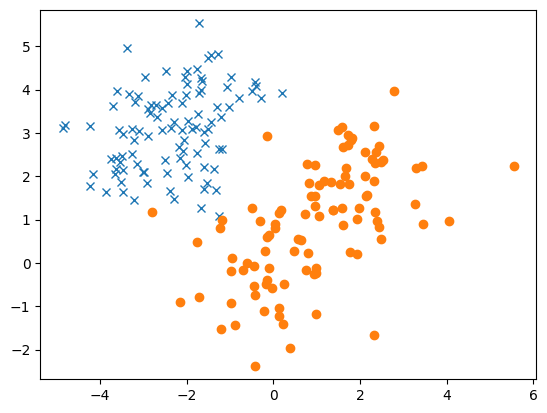

In [17]:
c1_x1, c1_x2 = np.random.multivariate_normal([-2.5,3], [[1, 0.3],[0.3, 1]], 100).T
c2_x1, c2_x2 = np.random.multivariate_normal([1,1], [[2, 1],[1, 2]], 100).T
c1_X = np.vstack((c1_x1, c1_x2)).T
c2_X = np.vstack((c2_x1, c2_x2)).T
train_X = np.concatenate((c1_X, c2_X))
train_y = np.concatenate((np.zeros(100), np.ones(100)))
# Shuffle the data
permutation = np.random.permutation(train_X.shape[0])
train_X = train_X[permutation, :]
train_y = train_y[permutation]
# Plot the data
plt.plot(c1_x1, c1_x2, 'x')
plt.plot(c2_x1, c2_x2, 'o')
plt.axis('equal')
plt.show()

We can then create a pytorch dataset object as follows. Often times, the default pytorch datasets will create these objects for you. Then, we can apply dataloaders to iterate over the dataset in batches.

In [18]:
dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
# We can create a dataloader that iterates over the dataset in batches.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
for x, y in dataloader:
    print("Batch x:", x)
    print("Batch y:", y)
    break

# Clean up the dataloader as we make a new one later
del dataloader

Batch x: tensor([[-3.5113,  1.8590],
        [-3.1178,  3.8620],
        [ 1.6830,  2.1970],
        [-2.8539,  3.4663],
        [-0.1537,  0.5909],
        [-0.1026, -0.1097],
        [ 1.7937,  2.8408],
        [-0.1430,  2.9392],
        [-1.6728,  1.2604],
        [ 2.5179,  2.3752]], dtype=torch.float64)
Batch y: tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 1.], dtype=torch.float64)


## Training Loop Example
Here is an example of training a full logistic regression model in pytorch. Note the extensive use of modules -- modules can be used for storing networks, computation steps etc.

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

epochs = 10
batch_size = 10
learning_rate = 0.01

num_features = dataset[0][0].shape[0]
model = Perceptron(num_features).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model.train() # Put model in training mode
for epoch in range(epochs):
    training_losses = []
    for x, y in tqdm(dataloader, unit="batch"):
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    print("Finished Epoch", epoch + 1, ", training loss:", np.mean(training_losses))

# We can run predictions on the data to determine the final accuracy.
with torch.no_grad():
    model.eval() # Put model in eval mode
    num_correct = 0
    for x, y in dataloader:
        x, y = x.float().to(device), y.float().to(device)
        pred = model(x)
        num_correct += torch.sum(torch.round(pred) == y).item()
    print("Final Accuracy:", num_correct / len(dataset))
    model.train() # Put model back in train mode

Using device cpu


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.7833559587597847


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.656832118332386


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.5628054216504097


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.49207343012094495


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.43795077949762345


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.3964300863444805


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.3637246459722519


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.3379991888999939


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 9 , training loss: 0.31731207594275473


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 10 , training loss: 0.30041554719209673
Final Accuracy: 0.94


# Task 1: CNN For FashionMNIST
Earlier in this course you trained SVMs and GDA models on MNIST. Now you will train a Convolutional Neural Network (CNN) on an MNIST-like dataset. Your deliverables are as follows:

1. Code for training a CNN on MNIST (can be in code appendix, tagged in your submission).
2. A plot of the training loss and validation loss for each epoch of training after trainnig for at least 8 epochs.
3. A plot of the training and validation accuracy, showing that it is at least 82% for validation by the end of training.

Below we will create the training and validation datasets for you, and provide a very basic skeleton of the code. Please leverage the example training loop from above.

Here are some of the components you should consider using:
1. `nn.Conv2d`
2. `nn.ReLU`
3. `nn.Linear`
3. `nn.CrossEntropyLoss`: if you choose to use `nn.CrossEntropyLoss` or `F.cross_entropy`, DO NOT add an explicit softmax layer in your neural network. PyTorch devs found it more numerically stable to combine softmax and cross entropy loss into a single module and if you explicitly attach a softmax layer at the end of your model, you would unintentionally be applying it twice, which can degrade performance.
5. `nn.MaxPooling2d` (though many implementations without it exist; for example, you can also do strided convolutions instead of a pooling layer!)

Here are challenges you will need to overcome:
1. You need to write code for plotting.
2. You need to find appropriate hyper-parameters to achieve good accuracy.

In [3]:
# Creating the datasets
transform = torchvision.transforms.ToTensor() # feel free to modify this as you see fit.

training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

validation_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

Before training a neural network, let's visualize our data first! Running the cell below will display the first 9 images in a 3 by 3 grid.

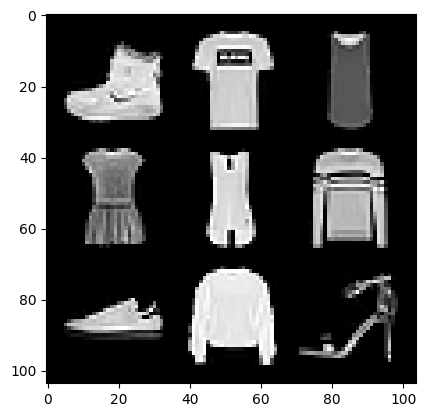

In [4]:
images = [training_data[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

In [5]:
class FashionMNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolution block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # Conv2D
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                                # MaxPool2D
        # Convolution block 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # Conv2D
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                                # MaxPool2D
        # Fully connected block
        self.flatten = nn.Flatten()                                                       # Flatten
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)                    # Linear
        self.dropout = nn.Dropout(p=0.5)                                                  # Dropout
        self.fc2 = nn.Linear(in_features=128, out_features=10)                            # Linear

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))  # [B,32,14,14]
        x = self.pool2(torch.relu(self.conv2(x)))  # [B,64,7,7]
        x = self.flatten(x)                        # [B,64*7*7]
        x = torch.relu(self.fc1(x))                # [B,128]
        x = self.dropout(x)
        x = self.fc2(x)                            # [B,10]
        return x

In [22]:
# ====== Create separate DataLoaders for training & testing ======
epochs = 10
batch_size = 32
learning_rate = 0.001

train_loader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=batch_size,
    shuffle=False
)

In [28]:
# ================== Send model and data to GPU ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

model = FashionMNIST_CNN()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

Using device cuda


In [29]:
# ============ Get ready to track losses and accuracies ============
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, epochs+1):

    train_running_loss = 0.0
    train_num_correct = 0
    train_num_datapoints = len(train_loader.dataset)

    val_running_loss = 0.0
    val_num_correct = 0
    val_num_datapoints = len(validation_loader.dataset)

    # =========================== Training ===========================
    model.train()

    for X, y in tqdm(train_loader, unit="batch"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() # Remove the gradients from the previous step
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * X.size(0)
        preds = logits.argmax(dim=1)
        train_num_correct += (preds == y).sum().item()

    avg_train_loss = train_running_loss / train_num_datapoints
    train_accuracy = train_num_correct / train_num_datapoints

    train_losses.append(avg_train_loss)
    train_accs.append(train_accuracy)

    # ========================== Validation ==========================
    model.eval() # Put model in eval mode

    with torch.no_grad():
        for X, y in tqdm(validation_loader, unit="batch"):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)

            val_running_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            val_num_correct += (preds == y).sum().item()

    avg_val_loss = val_running_loss / val_num_datapoints
    val_accuracy = val_num_correct / val_num_datapoints
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)

    print(f"Epoch {epoch:2d} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy*100:5.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy*100:5.2f}%")

print("Final Accuracy:", val_accs[-1])

  0%|          | 0/1875 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch  1 | Train Loss: 0.5580, Train Acc: 79.55% | Val Loss: 0.3550, Val Acc: 87.17%


  0%|          | 0/1875 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch  2 | Train Loss: 0.3680, Train Acc: 86.75% | Val Loss: 0.2936, Val Acc: 89.18%


  0%|          | 0/1875 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch  3 | Train Loss: 0.3091, Train Acc: 88.80% | Val Loss: 0.2705, Val Acc: 90.09%


  0%|          | 0/1875 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch  4 | Train Loss: 0.2774, Train Acc: 90.05% | Val Loss: 0.2563, Val Acc: 90.95%


  0%|          | 0/1875 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch  5 | Train Loss: 0.2526, Train Acc: 90.85% | Val Loss: 0.2500, Val Acc: 90.79%


  0%|          | 0/1875 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch  6 | Train Loss: 0.2365, Train Acc: 91.42% | Val Loss: 0.2404, Val Acc: 91.61%


  0%|          | 0/1875 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch  7 | Train Loss: 0.2191, Train Acc: 91.86% | Val Loss: 0.2465, Val Acc: 91.21%


  0%|          | 0/1875 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch  8 | Train Loss: 0.2043, Train Acc: 92.39% | Val Loss: 0.2492, Val Acc: 91.77%


  0%|          | 0/1875 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch  9 | Train Loss: 0.1923, Train Acc: 92.94% | Val Loss: 0.2380, Val Acc: 91.77%


  0%|          | 0/1875 [00:00<?, ?batch/s]

  0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 10 | Train Loss: 0.1807, Train Acc: 93.31% | Val Loss: 0.2377, Val Acc: 91.90%
Final Accuracy: 0.919


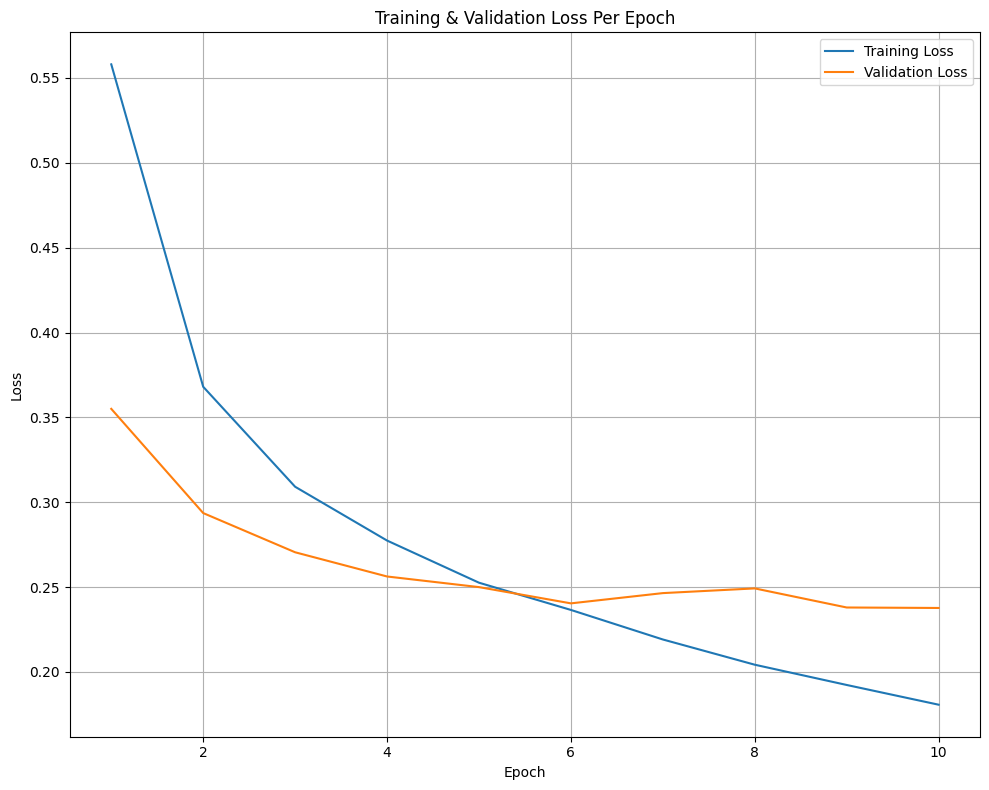

In [32]:
# ============ Plotting Train / Val Losses ============
plt.figure(figsize=(10,8))
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.title("Training & Validation Loss Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

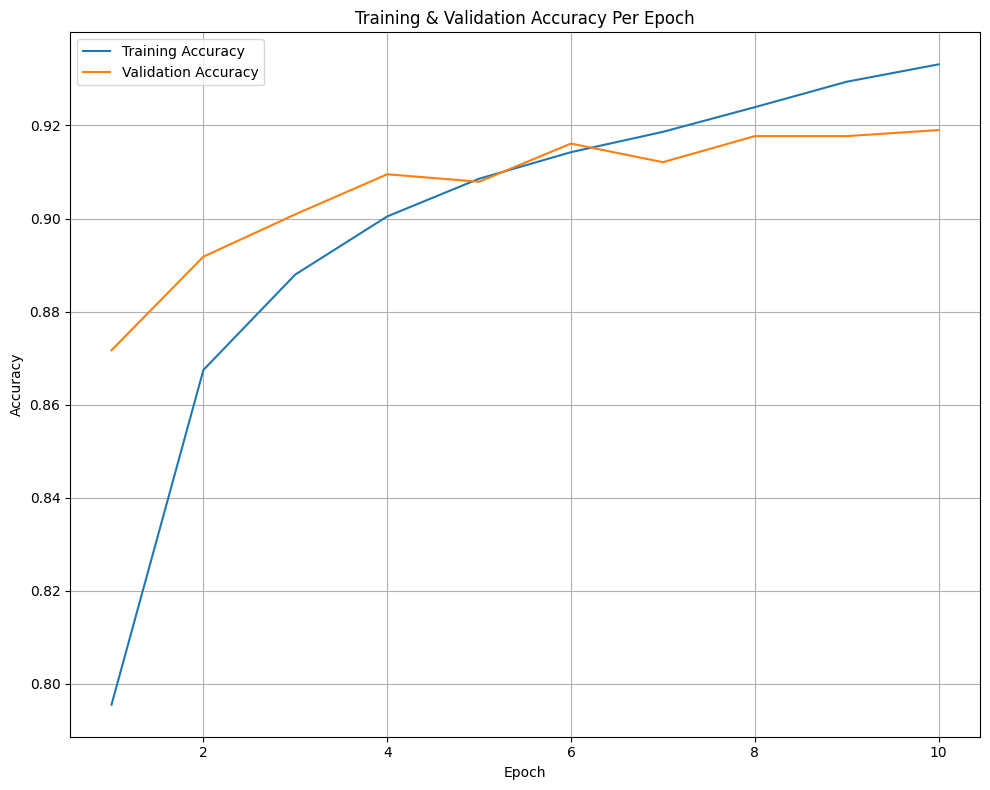

In [33]:
# ============ Plotting Train / Val Accuracies ============
plt.figure(figsize=(10,8))
plt.plot(range(1, epochs+1), train_accs, label="Training Accuracy")
plt.plot(range(1, epochs+1), val_accs, label="Validation Accuracy")
plt.title("Training & Validation Accuracy Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

After finishing this section, please go to the next notebook to finish the second part.